In [2]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

In [6]:
#Lists all archives in folder
file_folder_data_path = r"C:\Users\EstebanSoto\Downloads\VINICIO\VINICIO\2024-03_ANGSOL-REFLECTANCE\SERIES1"
file_list = os.listdir(file_folder_data_path)

#file extension
file_extension = ".ASC"

# filters a list of strings to create a new list containing only the elements that end with ".ASC"

def filter_substring_elements(path_strings, substring):
    filtered_paths = [path for path in path_strings if substring in path]
    return filtered_paths

# Filtering elements ending with ".ASC"
filtered_list = filter_substring_elements(file_list, file_extension)

# Displaying the filtered list
print(filtered_list)


['ANGSOL0001-1.Sample.ASC', 'ANGSOL0002-1.Sample.ASC', 'ANGSOL0003-1.Sample.ASC', 'ANGSOL0004-1.Sample.ASC', 'ANGSOL0005-1.Sample.ASC', 'ANGSOL0006-1.Sample.ASC', 'ANGSOL0007-1.Sample.ASC', 'ANGSOL0008-1.Sample.ASC', 'ANGSOL0009-1.Sample.ASC', 'ANGSOL0010-1.Sample.ASC', 'ANGSOL0011-1.Sample.Cycle1.ASC', 'ANGSOL0011-2.Sample.ASC', 'ANGSOL0011-2f.Sample.ASC', 'ANGSOL0011-3.Sample.ASC', 'ANGSOL0012-1.Sample.Cycle1.ASC', 'ANGSOL0012-2.Sample.ASC', 'ANGSOL0012-3.Sample.ASC', 'ANGSOL0013-1.Sample.ASC', 'ANGSOL0013-1.Sample.Cycle1.ASC', 'ANGSOL0013-2.Sample.ASC', 'ANGSOL0013-3.Sample.ASC', 'ANGSOL0017-1.Sample.ASC', 'ANGSOL0017-2.Sample.ASC', 'ANGSOL0017-3.Sample.ASC']


In [10]:
def get_metadata(file_location):
    
    #definitions
    #Logic to read ASCII data
    import pandas as pd
    import re

    def responses(str):
        re1 = "\d+/(\d+,\d+) \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)    
        else:
            return "",""
    def attenuator_settings(str):
        re1 = "S:(\d+,\d+) R:(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)    
        else:
            return "",""
    def slit_pmt_aperture(str):
        re1 = "\d+/servo \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1)    
        else:
            return ""
    
    f = open(file_location)
    metadata = {}
    df = pd.DataFrame()
    with f as data_file:
        for index, row in enumerate(data_file): #0-89

            row_str = row.strip()
            if index +1 == 3: #Filename and extension
                metadata["filename"]= row_str
            if index + 1 == 4: #date DD/MM/YYYY
                metadata["date"]= row_str
            if index + 1 == 5:#Time HH:MM:SS.SS
                metadata["time"]= row_str
            if index + 1 == 8:#user
                metadata["user"]= row_str
            if index + 1 == 9:#description
                metadata["description"]= row_str
            if index + 1 == 10:#minimum wavelength
                metadata["minimum_wavelength"]= row_str
            if index + 1 == 12:#equipment name
                metadata["equipment"]= row_str
            if index + 1 == 13:#equipment series
                metadata["series"]= row_str
            if index + 1 == 14:#data visualizer version, equipment version, date and time
                metadata["software"]= row_str
            if index + 1 == 21:#Operating mode
                metadata["operating_mode"]= row_str
            if index + 1 == 22: #Number of cycles
                metadata["cycles"]= row_str
            if index + 1 == 32: #range/servo
                metadata["slit_pmt"]= slit_pmt_aperture(row_str)
            if index + 1 == 33:
                metadata["response_ingaas"], metadata["response_pmt"]= responses(row_str)
            if index + 1 == 35: #pmt gain, if 0 is automatic
                metadata["pmt_gain"]= row_str
            if index + 1 == 36: #InGaAs detector gain
                metadata["ingaas_gain"]= row_str
            if index + 1 == 42:#monochromator wavelength nm
                metadata["monochromator_change"]= row_str
            if index + 1 == 43:#lamp change wavelength
                metadata["lamp_change"]= row_str
            if index + 1 == 44:#pmt wavelength
                metadata["pmt_change"]= row_str
            if index + 1 == 45:#beam selector
                metadata["beam_selector"]= row_str
            if index + 1 == 46:
                metadata["cbm"]= row_str
            if index + 1 == 47: #cbd status, on/off
                metadata["cbd_status"]= row_str
            if index + 1 == 48: #attenuator percentage
                metadata["attenuator_sample"], metadata["attenuator_reference"]= attenuator_settings(row_str)
            if index + 1 == 49:
                metadata["polarizer"]= row_str
            if index + 1 == 80:
                metadata["units"]= row_str
            if index + 1 == 81:
                metadata["measuring_mode"]= row_str
            if index + 1 == 84:
                metadata["maximum_wavelength"]= row_str
            if index + 1 == 85:
                metadata["step"]= row_str
            if index + 1 == 86:
                metadata["number_of_datapoints"]= row_str
            if index + 1 == 88:
                metadata["maximum_measurement"]= row_str
            if index + 1 == 89:
                metadata["minimum_measurement"]= row_str
            if index +1 == 90:
                break
        df = pd.read_csv(f, sep="\t", decimal =",", names=["wavelength", metadata["measuring_mode"]])
        f.close()
        return metadata

In [11]:
def jump_correction(file_folder_data_path, filename, metadata):
    #measuring_mode
    measuring_mode = metadata["measuring_mode"]
    
    #constants
    markersize = 1 #Marker size for plots

    # read text file into pandas DataFrame 
    full_path= file_folder_data_path + "\\" + filename
    
    #Read header
    lines = []
    with open(full_path) as myfile:
        lines = myfile.readlines()[0:90] 
    header = "".join(lines)

    #read body
    f = open(full_path)
    df = pd.read_csv(f, sep="\t", decimal = ",", skiprows=90,  
                     names=["wavelength", measuring_mode])
    
    #convert columns to float
    df['wavelength'] = df['wavelength'].astype(float)
    df[measuring_mode] = df[measuring_mode].astype(float)
    

    #This code finds the rows before and after the detector change
    #freq1 is the frequency before the change and freq2 is the frequency after the change
    wavelenght1 = 857.000000 #857
    wavelenght2 = 858.000000 #858
    
    #print("Loc")
    row1 = df.loc[ df['wavelength'] == wavelenght1]
    row2 = df.loc[ df['wavelength'] == wavelenght2]
    row22 = df.loc[ df['wavelength'] == wavelenght2 +1]
    row23 = df.loc[ df['wavelength'] == wavelenght2+2]
    row24 = df.loc[ df['wavelength'] == wavelenght2+3]
    row25 = df.loc[ df['wavelength'] == wavelenght2+4]
    
    #This code finds the values corresponding to those frequencies and creates a correction factor
    
    try:
        data1 = row1.iat[0,1]
        data2 = row2.iat[0,1]
        data22 = row22.iat[0,1]
        data23 = row23.iat[0,1]
        data24 = row23.iat[0,1]
        data25 = row23.iat[0,1]
    
        data2_avg = (data2 + data22+data23+data24+data25)/5
    
        correction_factor= data2_avg/data1 *0.98
    
        #Multiply all frequencies equal or greater than freq2 by correction_factor
        df2 = df
        df2.loc[df2["wavelength"] <= wavelenght2, [measuring_mode]] *= correction_factor

        #SAVE FILES
        #convert dataframe to numpy
        my_numpy_df_data = df.to_numpy()
        
        #Create new folder
        corrected_path = file_folder_data_path + "\\jump_corrected_files\\"
        if not os.path.exists(corrected_path):
            os.mkdir(corrected_path)
            
        #saves file, removes .ASC and removes .SAMPLE
        unnecessary_text = [".Sample", ".Cycle1"]
        temp_text = filename.replace('.ASC', ''+'.txt')
        for text in unnecessary_text:
            print(temp_text)
            temp_text = temp_text.replace(text, "")
        
        new_archive_name = corrected_path + temp_text
        
        with open(new_archive_name, 'wb') as f:
            np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
        with open(new_archive_name, "r") as f:
            data = f.read()
        with open(new_archive_name, "w") as f:
            f.write(data.replace("#DATA\n","#DATA"))
    except Exception as e:
        
        print(e)
        
    return
    

In [12]:
for file in filtered_list:

    #obtain metadata
    metadata = get_metadata(file_folder_data_path + "//"+file)
    
    #print(metadata)
    
    #Fix jump correction
    jump_correction(file_folder_data_path, file, metadata)

ANGSOL0001-1.Sample.txt
ANGSOL0001-1.txt
ANGSOL0002-1.Sample.txt
ANGSOL0002-1.txt
ANGSOL0003-1.Sample.txt
ANGSOL0003-1.txt
ANGSOL0004-1.Sample.txt
ANGSOL0004-1.txt
ANGSOL0005-1.Sample.txt
ANGSOL0005-1.txt
ANGSOL0006-1.Sample.txt
ANGSOL0006-1.txt
ANGSOL0007-1.Sample.txt
ANGSOL0007-1.txt
ANGSOL0008-1.Sample.txt
ANGSOL0008-1.txt
ANGSOL0009-1.Sample.txt
ANGSOL0009-1.txt
ANGSOL0010-1.Sample.txt
ANGSOL0010-1.txt
ANGSOL0011-1.Sample.Cycle1.txt
ANGSOL0011-1.Cycle1.txt
ANGSOL0011-2.Sample.txt
ANGSOL0011-2.txt
index 0 is out of bounds for axis 0 with size 0
ANGSOL0011-3.Sample.txt
ANGSOL0011-3.txt
ANGSOL0012-1.Sample.Cycle1.txt
ANGSOL0012-1.Cycle1.txt
ANGSOL0012-2.Sample.txt
ANGSOL0012-2.txt
ANGSOL0012-3.Sample.txt
ANGSOL0012-3.txt
ANGSOL0013-1.Sample.txt
ANGSOL0013-1.txt
ANGSOL0013-1.Sample.Cycle1.txt
ANGSOL0013-1.Cycle1.txt
ANGSOL0013-2.Sample.txt
ANGSOL0013-2.txt
ANGSOL0013-3.Sample.txt
ANGSOL0013-3.txt
ANGSOL0017-1.Sample.txt
ANGSOL0017-1.txt
ANGSOL0017-2.Sample.txt
ANGSOL0017-2.txt
ANGSOL00

In [13]:
#Lists all archives in folder
file_folder_data_path = r"C:\Users\EstebanSoto\Downloads\VINICIO\VINICIO\2024-03_ANGSOL-REFLECTANCE\SERIES1\jump_corrected_files"
file_list = os.listdir(file_folder_data_path)

#file extension
file_extension = ".txt"

# filters a list of strings to create a new list containing only the elements that end with ".ASC"

def filter_substring_elements(path_strings, substring):
    filtered_paths = [path for path in path_strings if substring in path]
    return filtered_paths

# Filtering elements ending with ".ASC"
filtered_list = filter_substring_elements(file_list, file_extension)

# Displaying the filtered list
print(filtered_list)


['ANGSOL0001-1.txt', 'ANGSOL0002-1.txt', 'ANGSOL0003-1.txt', 'ANGSOL0004-1.txt', 'ANGSOL0005-1.txt', 'ANGSOL0006-1.txt', 'ANGSOL0007-1.txt', 'ANGSOL0008-1.txt', 'ANGSOL0009-1.txt', 'ANGSOL0010-1.txt', 'ANGSOL0011-1.txt', 'ANGSOL0011-2.txt', 'ANGSOL0011-3.txt', 'ANGSOL0012-1.txt', 'ANGSOL0012-2.txt', 'ANGSOL0012-3.txt', 'ANGSOL0013-1.txt', 'ANGSOL0013-2.txt', 'ANGSOL0013-3.txt', 'ANGSOL0017-1.txt', 'ANGSOL0017-2.txt', 'ANGSOL0017-3.txt']


In [ ]:

# Generate some noisy data
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x) + np.random.normal(0, 0.1, 100)  # Sinusoidal signal with noise

# Apply Savitzky-Golay filter
window_length = 9  # Window length (odd number)
polyorder = 2  # Polynomial order
y_smooth = savgol_filter(y, window_length, polyorder)

# Plot original and smoothed data
plt.plot(x, y, label='Original')
plt.plot(x, y_smooth, label='Smoothed')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Savitzky-Golay Filtering')
plt.legend()
plt.show()
#

In [19]:
def apply_filter(file_folder_data_path, filename, metadata):
    #measuring_mode
    measuring_mode = metadata["measuring_mode"]
    
    #constants
    markersize = 1 #Marker size for plots

    # read text file into pandas DataFrame 
    full_path= file_folder_data_path + "\\" + filename
    
    #Read header
    lines = []
    with open(full_path) as myfile:
        lines = myfile.readlines()[0:90] 
    header = "".join(lines)

    #read body
    f = open(full_path)
    df = pd.read_csv(f, sep="\t", decimal = ",", skiprows=90,  
                     names=["wavelength", measuring_mode])
    
    #convert columns to float
    df['wavelength'] = df['wavelength'].astype(float)
    y = df[measuring_mode] = df[measuring_mode].astype(float)
    
    #Apply filter
    
    # Apply Savitzky-Golay filter
    window_length = 9  # Window length (odd number)
    polyorder = 2  # Polynomial order
    y_smooth = savgol_filter(y, window_length, polyorder)
    
    df["smooth"] = y_smooth
    
    #print
    df.plot("wavelength", measuring_mode)
    df.plot("wavelength", "smooth", color = "r")
    
        
    return
    

C:\Users\EstebanSoto\anaconda3\envs\workshop\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


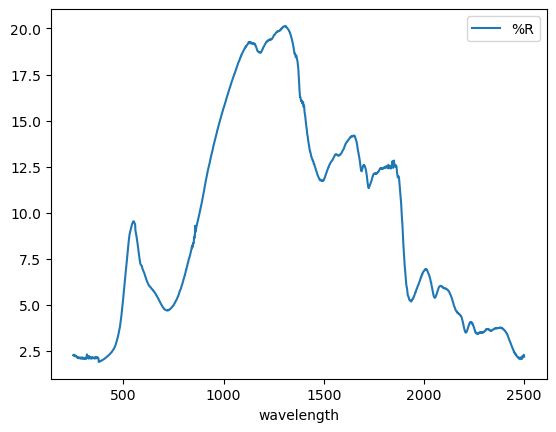

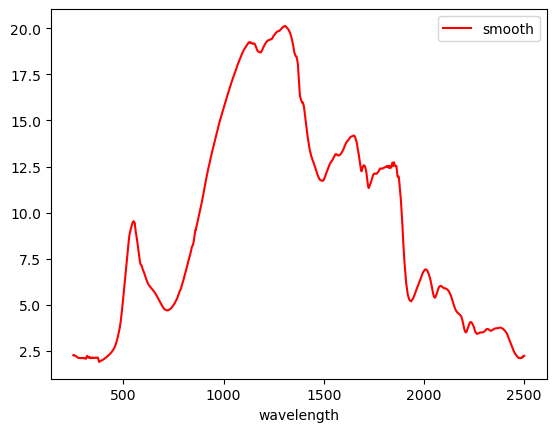

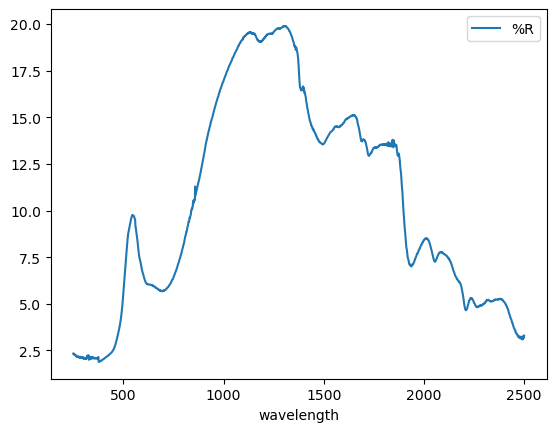

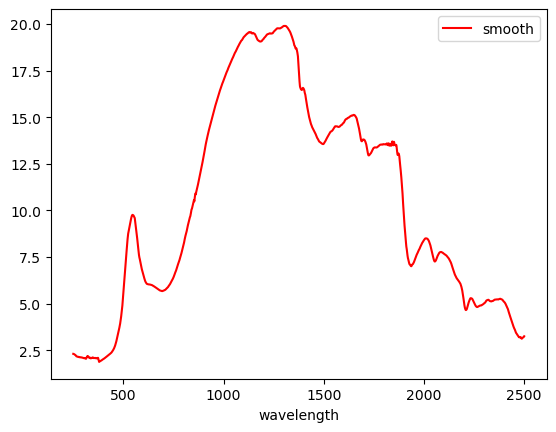

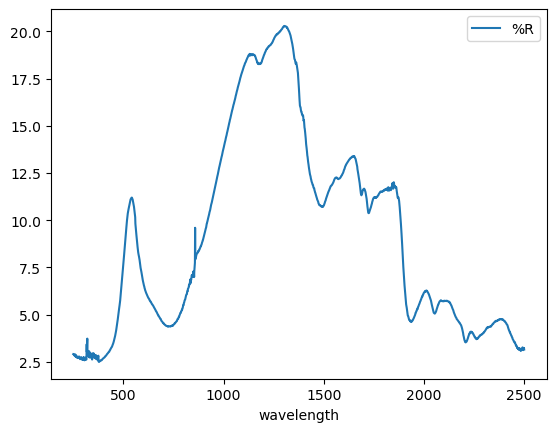

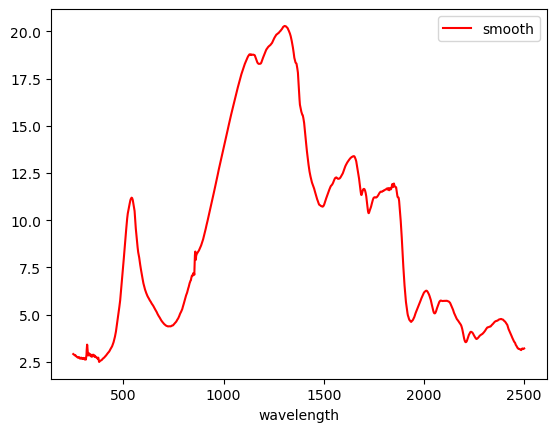

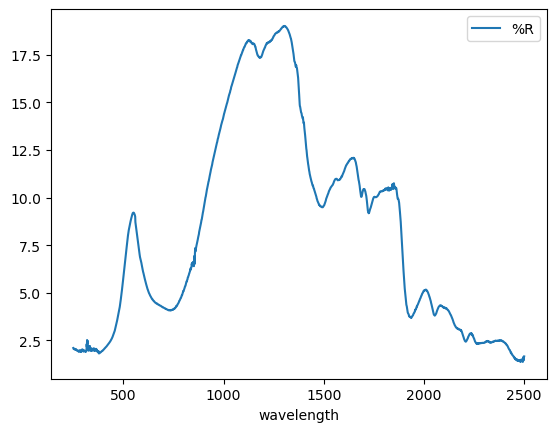

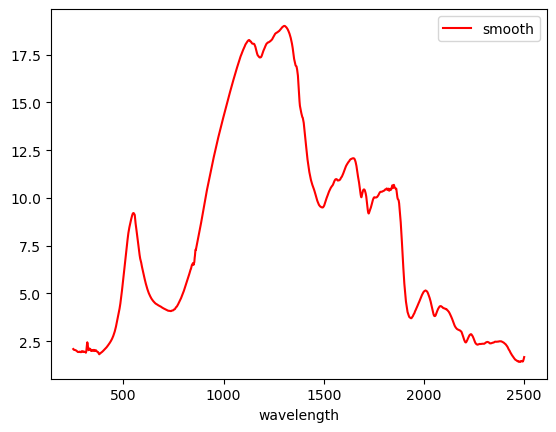

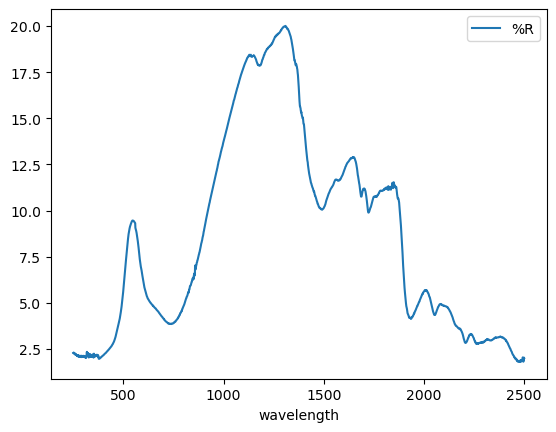

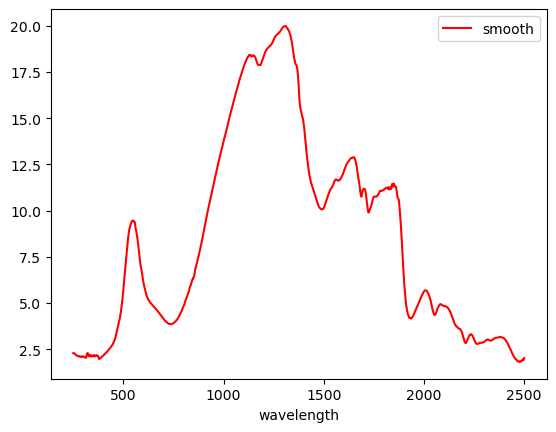

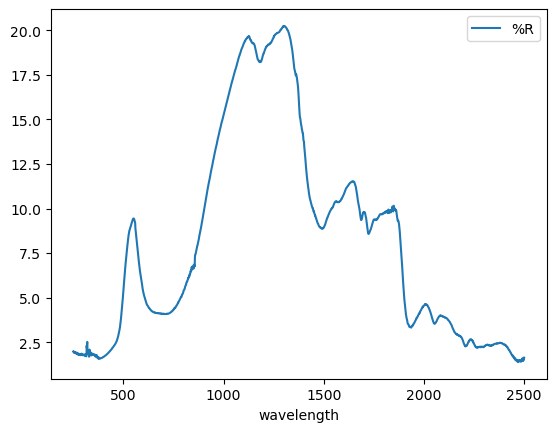

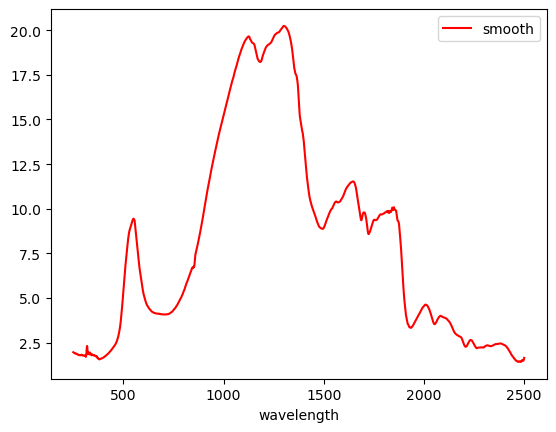

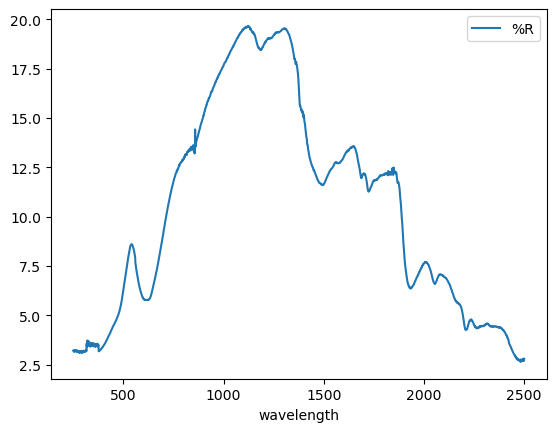

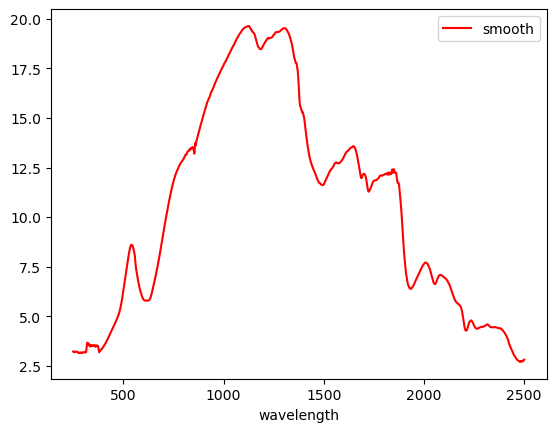

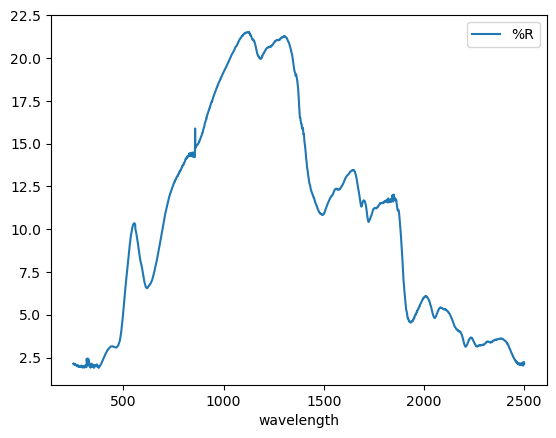

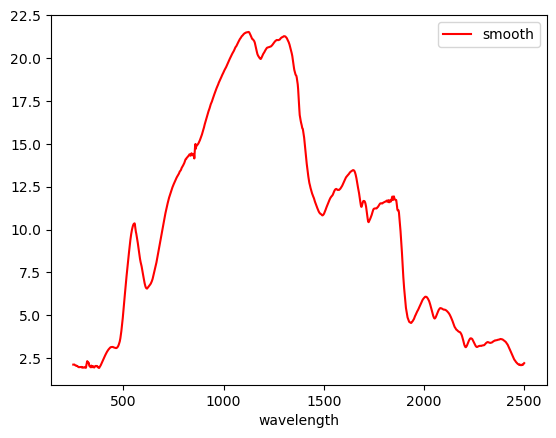

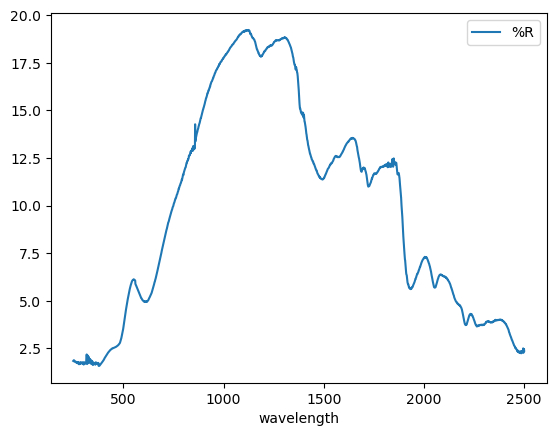

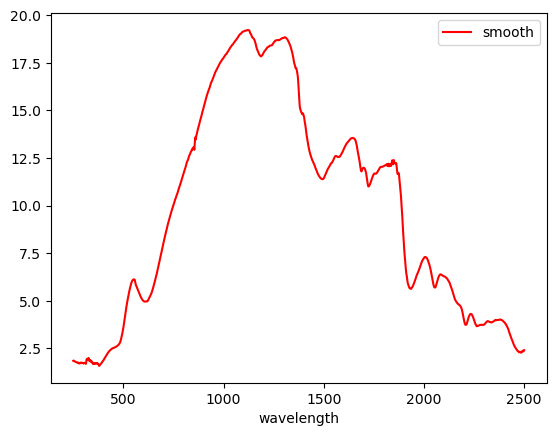

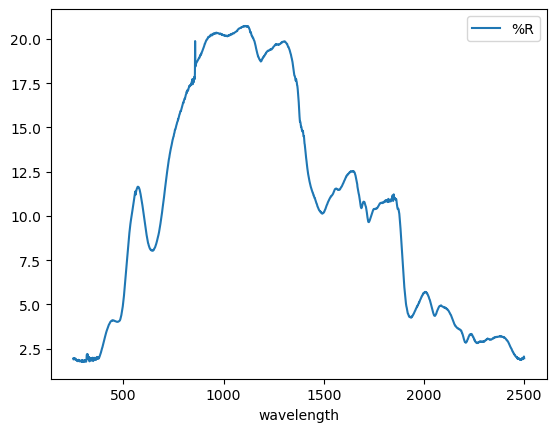

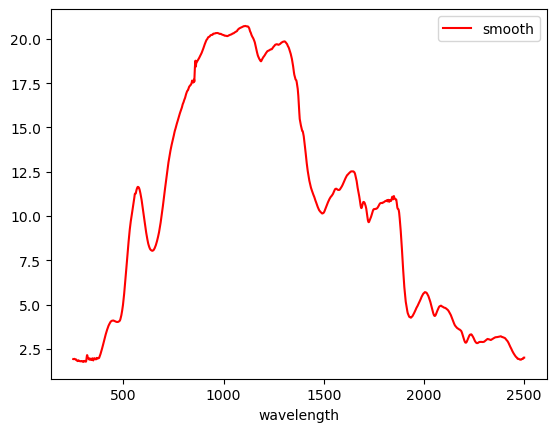

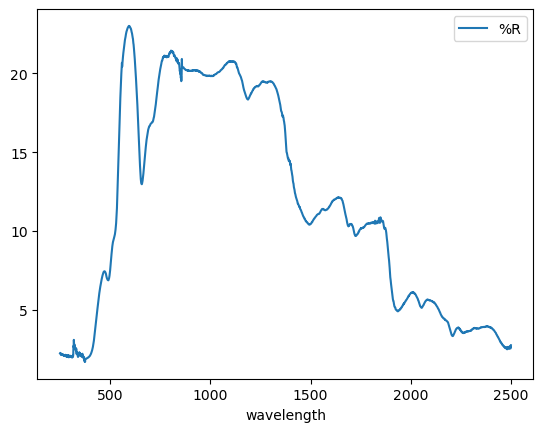

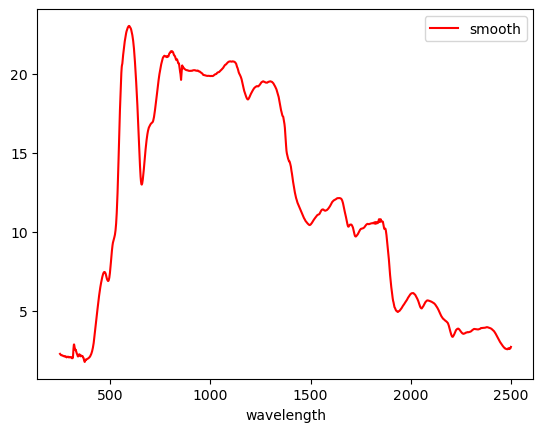

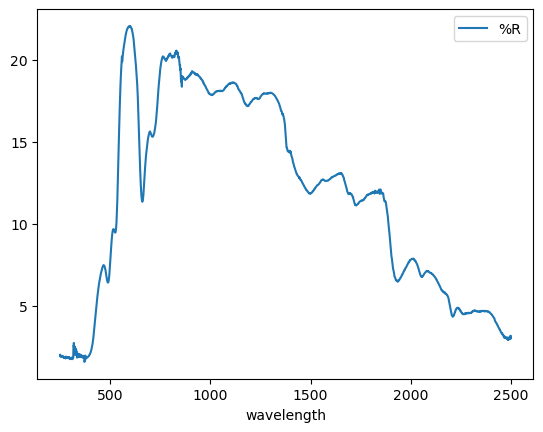

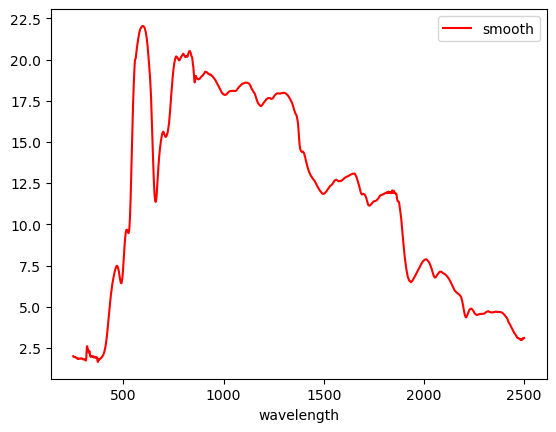

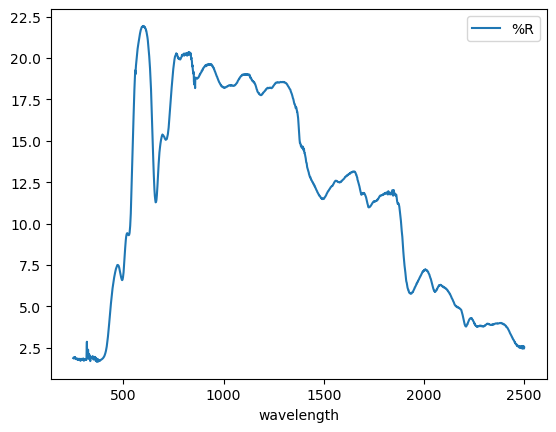

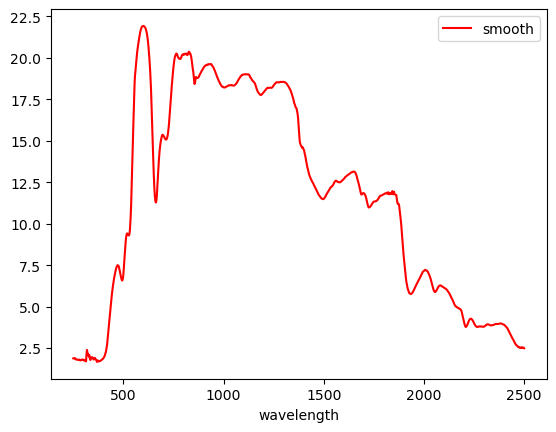

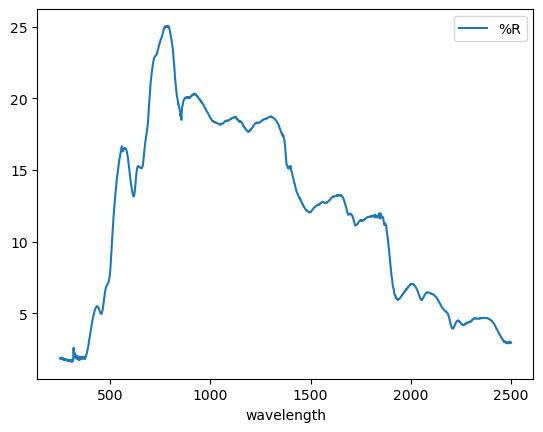

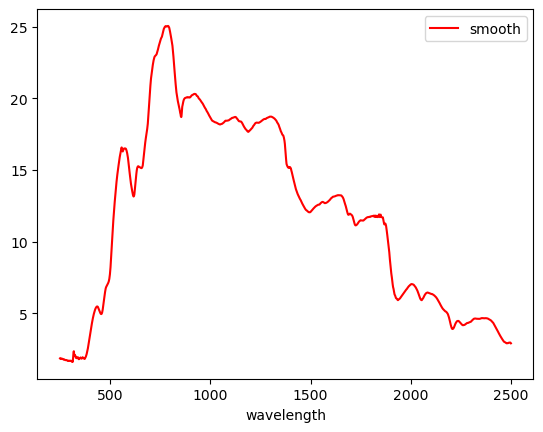

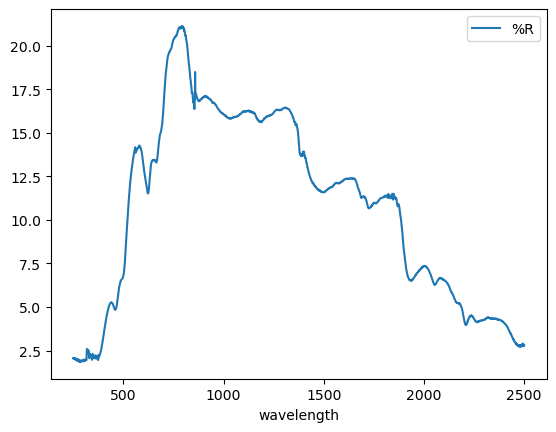

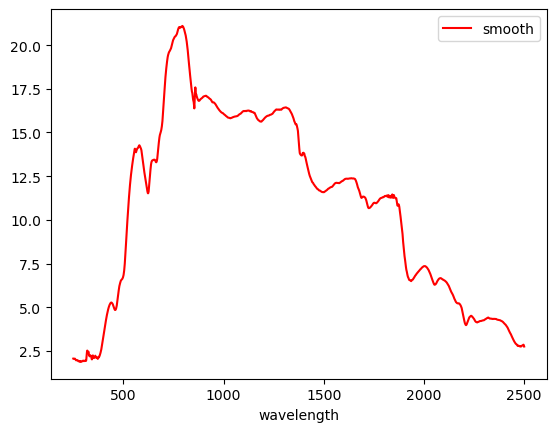

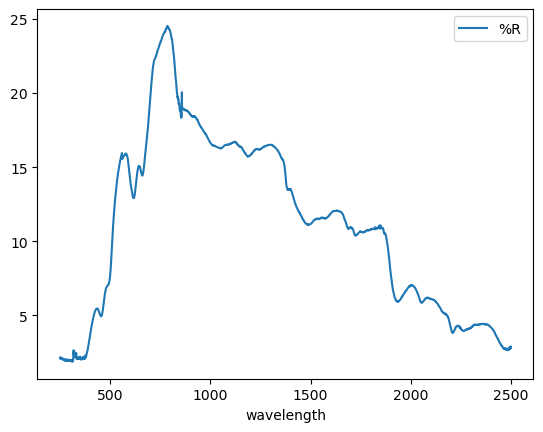

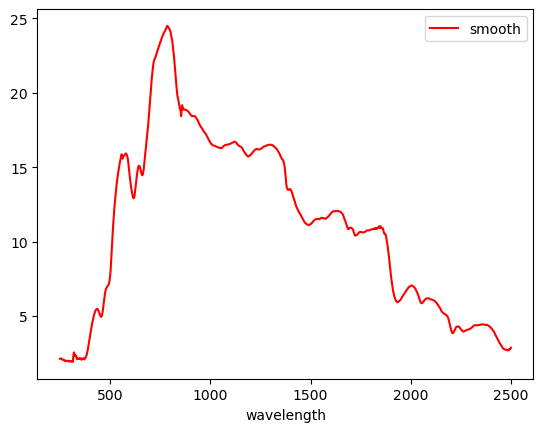

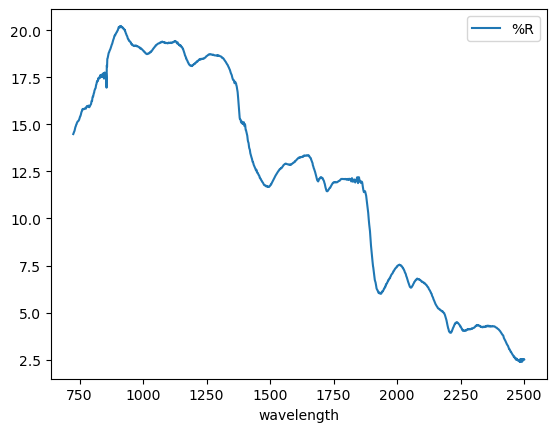

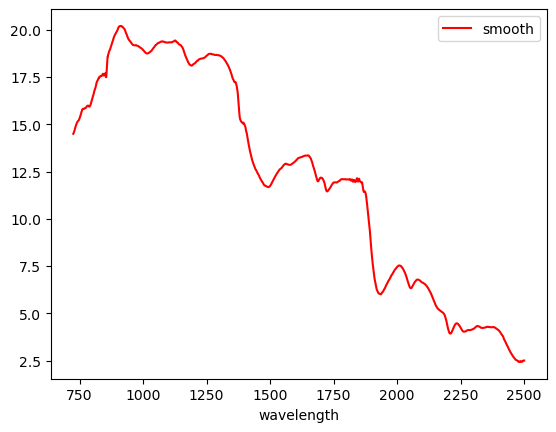

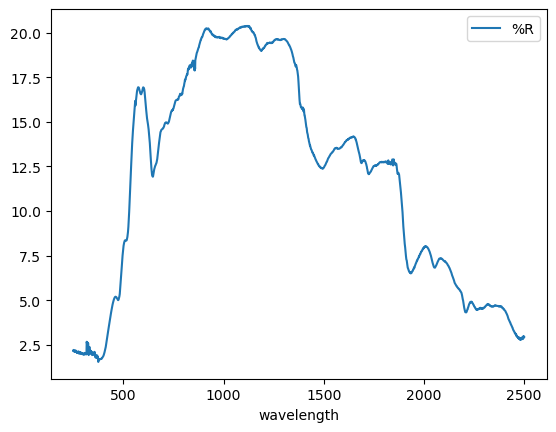

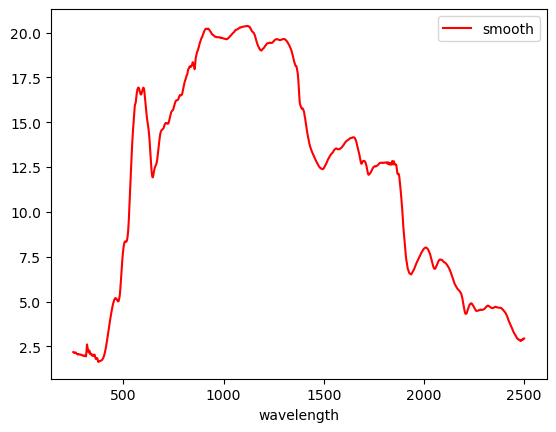

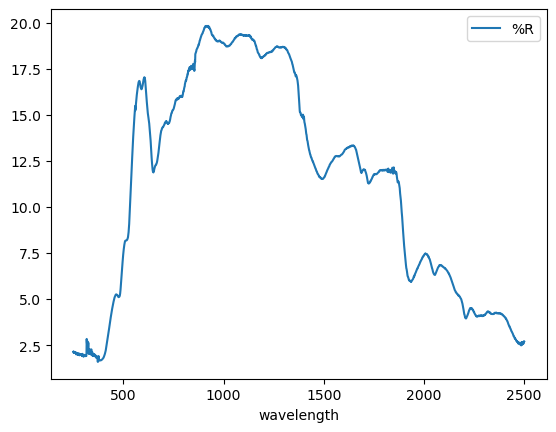

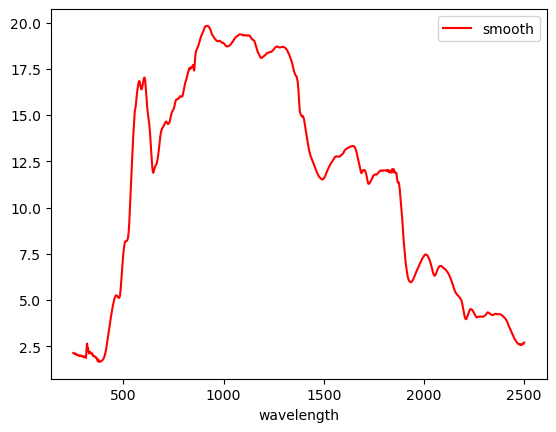

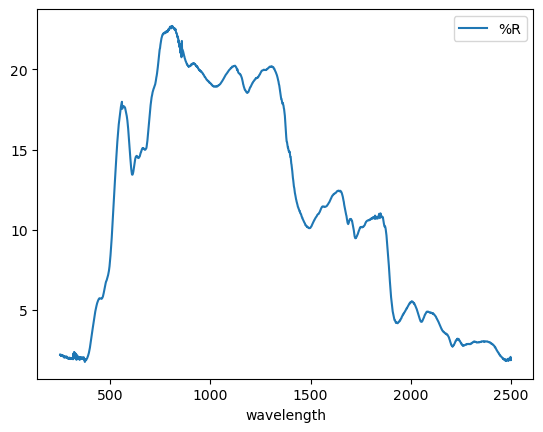

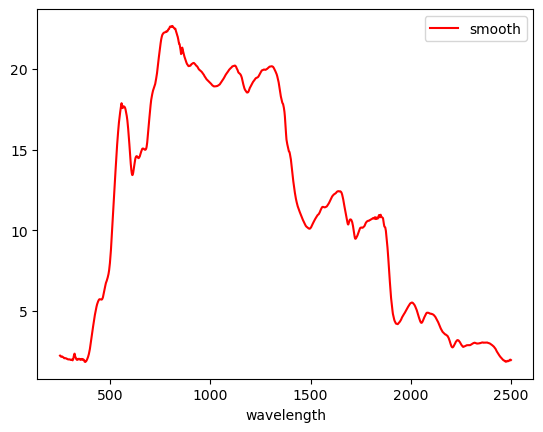

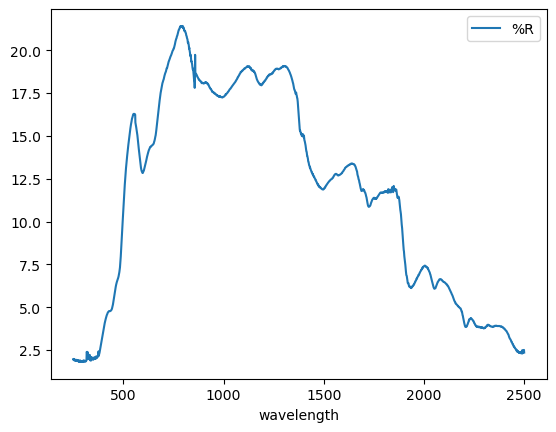

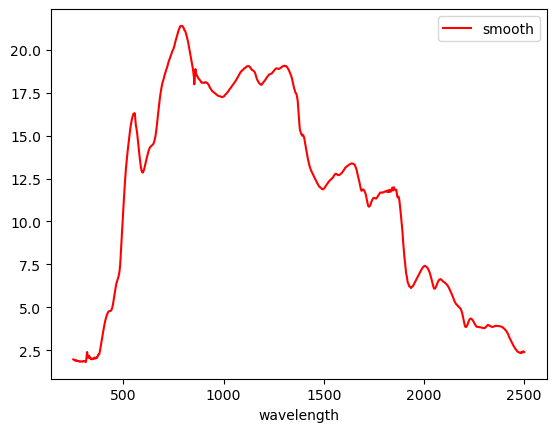

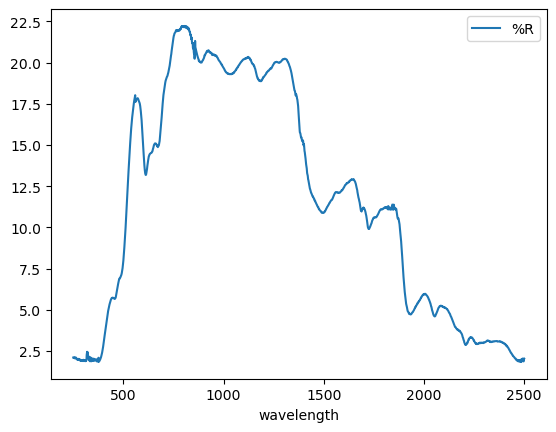

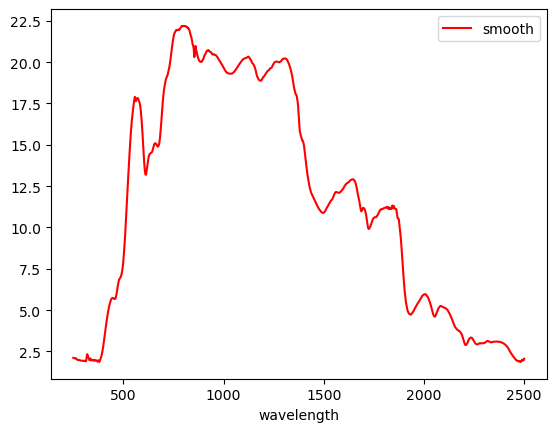

In [20]:
for file in filtered_list:

    #obtain metadata
    metadata = get_metadata(file_folder_data_path + "//"+file)
    
    #Fix jump correction
    apply_filter(file_folder_data_path, file, metadata)